<h1> Finite Element Analysis </h1>
Using FEniCS to simulate displacement, stress near a crack in a rectangular elastomer (2D) under neo-Hookean hyperelasticity, with the intention of computing the J-integral of the crack tip.

Importing packages

In [1]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np
import gmsh
import meshio
from ufl import *

Key parameters

In [2]:
## Problem and Mesh geometry
stretch_ratio = 1.15  # Vertical stretching ratio
l_x, l_y = 5,5  # Domain dimensions
crack_size = 0.5
mesh_size = 0.2
refine_radius = 0.2 # radius from crack within which mesh is refined; at most crack_size
refine_ratio = 30

## Material Property
E = 3  #Young's modulus
nu = 0.5  # Poisson ratio; at most 0.5
mu = E/2/(1+nu)  # Shear modulus

## For J-integral 
contour_radius = 0.3 # radius of circular arc contour taken
num_points = 20 # Number of points taken on the contour, J-integral seems rather insensitive to this once over 20

Mesh construction

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.007388s, CPU 0.009284s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.119058s, CPU 0.11907s)
Info    : 3703 nodes 7506 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'



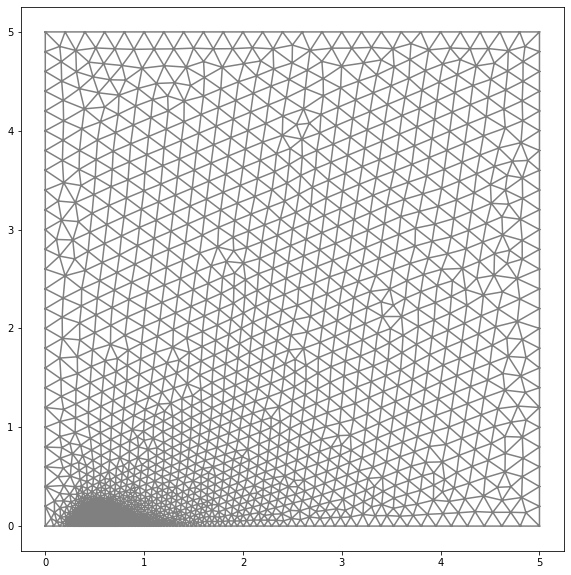

In [3]:
def create_mesh(l_x,l_y, mesh_size, crack_size, refine_radius, refine_ratio):
    filename = 'mesh'
    gmsh.initialize()
    gmsh.model.add('mesh')
    p1 = gmsh.model.geo.addPoint(0, 0, 0, mesh_size)
    p2 = gmsh.model.geo.addPoint(l_x, 0, 0, mesh_size)
    p3 = gmsh.model.geo.addPoint(l_x, l_y, 0, mesh_size)
    p4 = gmsh.model.geo.addPoint(0, l_y, 0, mesh_size)
    p5 = gmsh.model.geo.addPoint(crack_size, 0, 0, mesh_size/refine_ratio)
    p6 = gmsh.model.geo.addPoint(crack_size + refine_radius, 0, 0, mesh_size/refine_ratio)
    p7 = gmsh.model.geo.addPoint(crack_size - refine_radius, 0, 0, mesh_size/refine_ratio)

    c1 = gmsh.model.geo.addCircleArc(p6,p5,p7)
    c2 = gmsh.model.geo.addLine(p6, p2)
    c3 = gmsh.model.geo.addLine(p2, p3)
    c4 = gmsh.model.geo.addLine(p3, p4)
    c5 = gmsh.model.geo.addLine(p4, p1)
    c6 = gmsh.model.geo.addLine(p1, p7)
    c7 = gmsh.model.geo.addLine(p7, p5)
    c8 = gmsh.model.geo.addLine(p5, p6)

    l1 = gmsh.model.geo.addCurveLoop([c2, c3, c4, c5, c6, -c1])
    l2 = gmsh.model.geo.addCurveLoop([c1, c7, c8])
    s1 = gmsh.model.geo.addPlaneSurface([l1])
    s2 = gmsh.model.geo.addPlaneSurface([l2])

    gmsh.model.geo.synchronize()
    gmsh.model.mesh.generate(2)
    gmsh.option.setNumber("Mesh.SaveAll", 1)
    gmsh.write(filename + ".msh")
    gmsh.finalize()

    inmsh = meshio.read(filename + ".msh")
    # delete third (obj=2) column (axis=1), this strips the z-component
    outpoints = np.delete(arr=inmsh.points, obj=2, axis=1) 
    outmsh = meshio.Mesh(points=outpoints,
                        cells=[('triangle', inmsh.get_cells_type("triangle"))],
    #                       cell_data={'Subdomain': [inmsh.cell_data_dict['gmsh:physical']['triangle']]},
                        field_data=inmsh.field_data)
    meshio.write(filename + ".xdmf", outmsh)

    with fe.XDMFFile(fe.MPI.comm_world, filename + ".xdmf") as xdmf_infile:
        mesh = fe.Mesh()
        xdmf_infile.read(mesh)

    return mesh

mesh = create_mesh(l_x,l_y, mesh_size, crack_size, refine_radius, refine_ratio)
plt.figure(figsize=(10,10))
fe.plot(mesh)

# plt.xlim([crack_size - 2*refine_radius, crack_size + 2*refine_radius])
# plt.ylim([0,4*refine_radius])

Solving variational problem

In [4]:
# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))

# --------------------
# Geometry
# --------------------
# ds(0) is the bottom edge (including crack), ds(1) is the other 3 edges
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

right = fe.AutoSubDomain(lambda x: fe.near(x[0],  l_x))
right.mark(boundaries, 1)
top = fe.AutoSubDomain(lambda x: fe.near(x[1],  l_y))
top.mark(boundaries, 1)
left = fe.AutoSubDomain(lambda x: fe.near(x[0],  0))
left.mark(boundaries, 1)
bottom = fe.AutoSubDomain(lambda x: fe.near(x[1], 0) and x[0]>crack_size)  # excludes crack, for use in Dirichlet BC

ds = fe.ds(domain = mesh, subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------

#element for pressure field
Element1 = fe.FiniteElement("CG", mesh.ufl_cell(), 1)
#element for displacement field
Element2 = fe.VectorElement("CG", mesh.ufl_cell(), 2)

# Defining the mixed function space
W_elem = fe.MixedElement([Element1, Element2])
W = fe.FunctionSpace(mesh, W_elem)

## Define functions
w_trial = fe.TrialFunction(W)            # Variational Problem seeks stationary point in the space of TrialFunction,
w_test  = fe.TestFunction(W)            # such that it is orthogonal to all TestFunctions
w = fe.Function(W)
p,u = fe.split(w)

# --------------------
# Continuum Mechanics
# --------------------

## Defining some continuum mechanics relations
d = u.geometric_dimension()
I = fe.Identity(d)             # Identity tensor
F = I + fe.grad(u)             # Deformation gradient
C = F.T*F                   # Right cauchy stress tensor
b = F*F.T                   # Left cauchy stress tensor
Ib = fe.tr(b)                  # First invariant of b tensor
J  = fe.det(F)                 # Jacobian of deformation gradient tensor

## Strain energy density function
SEDF = mu/2*(Ib - 2) # Constitutive equation for Neo-Hookean material
psi = SEDF*fe.dx - p*(J - 1)*fe.dx  # Strain energy density with Lagrange multiplier for incompressibility

# Gateaux derivative in the direction of the test function
F = fe.derivative(psi, w, fe.TestFunction(W))      # This is the (non-linear) functional for the Variational Problem
Jac = fe.derivative(F, w, fe.TrialFunction(W))     # Compute Jacobian of F, for solver to apply Newton's Method 

# --------------------
# Bouondary Conditions
# --------------------

# Dirichlet Boundary conditions
W_bottom = fe.Expression(('-x[0]*(1-1/stretch_ratio)','0.0'), 
    degree=1, stretch_ratio = stretch_ratio)
W_top = fe.Expression(('-x[0]*(1-1/stretch_ratio)','l_y*strain'), 
    degree=1, stretch_ratio = stretch_ratio, strain = stretch_ratio-1, l_y = l_y)
bc_bottom = fe.DirichletBC(W.sub(1), W_bottom, bottom)
bc_top = fe.DirichletBC(W.sub(1), W_top, top)
bc_all = [bc_bottom, bc_top]

# Defining and solving problem
problem = fe.NonlinearVariationalProblem(F, w, bc_all, Jac)
solver = fe.NonlinearVariationalSolver(problem)
prm = solver.parameters
# prm["newton_solver"]["relative_tolerance"] = 1E-5
solver.solve()

(p, u) = w.split(True)

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.347e-01 (tol = 1.000e-10) r (rel) = 7.001e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 7.726e-02 (tol = 1.000e-10) r (rel) = 4.016e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 7.373e-02 (tol = 1.000e-10) r (rel) = 3.832e-03 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 3.846e-02 (tol = 1.000e-10) r (rel) = 1.999e-03 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.338e-02 (tol = 1.000e-10) r (rel) = 6.956e-04 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 1.010e-03 (tol = 1.000e-10) r (rel) = 5.250e-05 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 3.521e-05 (tol = 1.000e-10) r (rel) = 1.830e-06 (tol = 1.000e-09)
  Newton iteration 8: r (abs) = 1.279e-08 (tol = 1.000e-10) r (rel) = 6.646e-10 (tol = 1.000e-09)
  Newton solver finished in 8 iterations and 8 linear solver iterations.


Object cannot be plotted directly, projecting to piecewise linears.


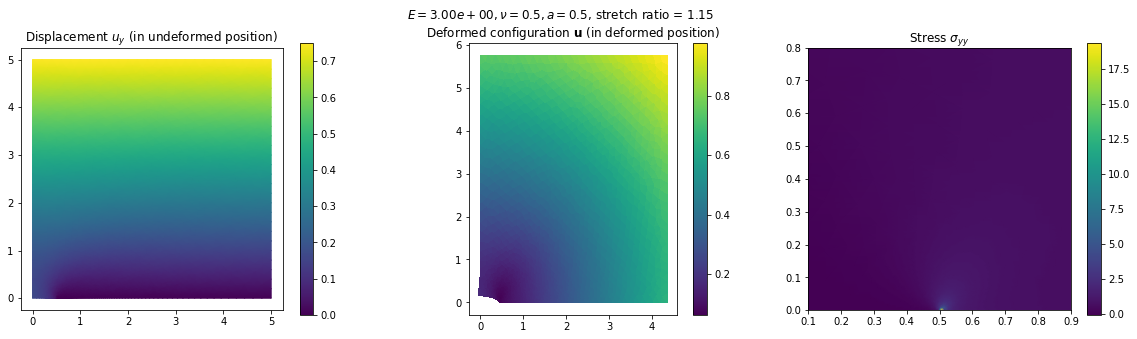

In [5]:
# --------------------
# Post-process
# --------------------
plt.figure(figsize=(20,5))
plt.suptitle('$E = {:.2e}, \\nu = {}, a = {}$, stretch ratio = {}'
    .format(E,nu,crack_size, stretch_ratio))

plt.subplot(1,3,1)
ax1 = fe.plot(u.sub(1),mode='color')
plt.colorbar(ax1)
plt.title('Displacement $u_y$ (in undeformed position)')

# ax1.set_clim([0,0.2])
# plt.xlim([0, 2*crack_size])
# plt.ylim([0, 2*crack_size])

plt.subplot(1,3,2)
ax2 = fe.plot(u, mode= 'displacement')
plt.colorbar(ax2)
plt.title('Deformed configuration $\mathbf{u}$ (in deformed position)')
# ax1.set_clim(ax2.get_clim())

plt.subplot(1,3,3)

stress = mu * b - p * I
V0 = fe.TensorFunctionSpace(mesh, "Lagrange", 1) #Not sure about the choice of function spaces
stress_1 = fe.project(stress, V0)
ax3 = fe.plot(stress_1[1, 1], mode = 'color')
plt.xlim([crack_size - 2*refine_radius, crack_size + 2*refine_radius])
plt.ylim([0,4*refine_radius])
plt.colorbar(ax3)
plt.title(r'Stress $\sigma_{yy}$')
plt.show()

Old J-integral

In [6]:
# # Get grad(u) via projection
grad_u_sp = fe.TensorFunctionSpace(mesh,"CG", 2)
grad_u = fe.project(grad(u),grad_u_sp)

#Integrating around the 3 edges to obtain J integral
n = fe.FacetNormal(mesh)
J_int = (SEDF *abs(n[0]) - as_tensor(stress_1[i, j]*n[j]*grad_u[i,0] )) * ds(1)

J1 = fe.assemble(J_int)
kappa1= 2*J1/(crack_size*mu*(stretch_ratio**2 + stretch_ratio**(-2) -2 ))
print(J1)
print(kappa1)


0.33171261744734254
16.871675945401783


J-integral: Using a circular arc contour around crack tip

In [7]:
assert contour_radius < crack_size

# Defining new mesh for contour
center =np.array([crack_size,0])
mesh_points = [center + contour_radius*np.array([np.cos(t), np.sin(t)]) for t in np.linspace(0, np.pi, num_points+1)]
    
tdim, gdim = 1, len(center)
contour_mesh = fe.Mesh()
editor = fe.MeshEditor()
editor.open(contour_mesh, 'interval', tdim, gdim)
editor.init_vertices(num_points+1)
editor.init_cells(num_points)
for vi, v in enumerate(mesh_points): editor.add_vertex(vi, v)
for ci in range(num_points): editor.add_cell(ci, np.array([ci, ci+1], dtype='uintp'))

editor.close()
# fe.plot(contour_mesh)

# Projecting quantities to the spaces of the new mesh

V_contour = fe.VectorFunctionSpace(contour_mesh,'CG',1)
normal_e = fe.Expression(('(x[0]-a)/r','x[1]/r'), 
    degree=1, a = crack_size, r = contour_radius)
normal = fe.interpolate(normal_e, V_contour)

V_scalar = fe.FunctionSpace(mesh,'CG',1)
V_scalar_contour = fe.FunctionSpace(contour_mesh,'CG',1)
SEDF_int = fe.project(SEDF, V_scalar)
SEDF_contour = fe.interpolate(SEDF_int, V_scalar_contour)

gradu_sp = fe.TensorFunctionSpace(mesh,"DG", 1)
gradu = fe.project(grad(u),gradu_sp)
gradu_sp_contour = fe.TensorFunctionSpace(contour_mesh,"DG", 1)
gradu_contour = fe.interpolate(gradu, gradu_sp_contour)
stress_1_contour = fe.interpolate(stress_1, gradu_sp_contour)

# Assembling the J-integral
J_integrand =  SEDF_contour * normal[1] - as_tensor(stress_1_contour[i, j]*normal[j]*gradu_contour[i,k], (k) )[0]
J2 = fe.assemble(J_integrand*dx(contour_mesh))
kappa2 = 2*J2/(crack_size*mu*(stretch_ratio**2 + stretch_ratio**(-2) -2 ))

In [8]:
# Output and comparison
print('a = {}, stretch ratio = {}'.format(crack_size, stretch_ratio))

# J-integral from finite element solutions
print('J1 = {}, kappa1 = {}'.format(J1, kappa1))
print('J2 = {}, kappa2 = {}'.format(J2, kappa2))

# G from LEFM, assuming infinite rectangular elastomer 
print('G (infinite elastomer) = {}'.format(3/4 *(stretch_ratio-1)**2 *E *crack_size * pi*1.122**2 ))
# G from LEFM, assuming finite rectangular elastomer
print('G (finite elastomer) = {}'.format(3/4 *(stretch_ratio-1)**2 *E *crack_size *(1.99- 0.41* (crack_size/l_x) + 18.7 *(crack_size/l_x)**2 -38.48 *(crack_size/l_x)**3 + 53.85 *(crack_size/l_x)**4)**2))

a = 0.5, stretch ratio = 1.15
J1 = 0.33171261744734254, kappa1 = 16.871675945401783
J2 = 0.07948050608202131, kappa2 = 4.042563568765274
G (infinite elastomer) = 0.10010842462995628
G (finite elastomer) = 0.11193717642532021
